In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import plot1qbit
import glob
import h5py
from ipywidgets import interactive

In [2]:
def plot_single_sample(data, ax):
    ax.imshow(data)
    ax.set_axis_on()
    ax.set_yticks([])
    ax.set_xticks([])

def plot_grid(data, N=None, M=None, label=None):
    if N is None or M is None:
        N=2
        M=5
    s = 1.
    fig, axs = plt.subplots(N,M,figsize=(M*s,N*s))
    for i in range(N):
        for j in range(M):
            try:
                plot_single_sample(data[i*M+j], axs[i,j])
            except IndexError:
                pass
    plt.tight_layout()
    if label:
        fig.suptitle(label)
    fig.show()
    

    
def load_data_for_plot(var, template, npz_file=None):
    d = np.load(template.format(var))
    if npz_file is not None:
        print([i for i in d.keys()])
        d = d[npz_file]
    return d
  
    
def plt_samples(iter_, template):
    try:
        d = np.load(template.replace("{i}", str(iter_)))
        plot_grid(d, label=f"Step {iter_}")
    except FileNotFoundError as e:
        #print(e)
        pass
        
def plt_general(var, template, label_template="", npz_file=None, n=None, m=None):
    try:
        d = load_data_for_plot(var, template, npz_file)

        plot_grid(d, label=label_template.format(var), N=n, M=m)
    except FileNotFoundError:
        pass

def plot_overview(glob_pattern="./workdir_SSM_radermacher/samples/iter_*"):
    sample_dirs = sorted(glob.glob(glob_pattern), key=lambda x: int(x.split("_")[-1]))
    Ts = [s.replace(glob_pattern.replace("*",""),"") for s in sample_dirs]

    Nt = len(Ts)

    M, N = [int(np.ceil(np.sqrt(Nt))),]*2

    count = 0

    fig, ax = plt.subplots(M, N, figsize=(M,N))
    if N==1:
        ax=np.array([[ax]])

    for m in range(M):
        for n in range(N):
            if count >= Nt:
                ax[m, n].set_axis_off()
            else:
                d = load_data_for_plot(var="", template=sample_dirs[count] + "/sample.np")
                plot_single_sample(d[np.random.randint(0,d.shape[0])], ax[m, n])
                if n==0:
                    ax[m, n].set_ylabel(str(Ts[count]), size=8)
                    ax[m, n].set_axis_on()
                    ax[m, n].set_xticks([])
                    ax[m, n].set_yticks([])
                count+=1
    plt.show()
        
def plot_overview_h5(h5="debug_data.h5"):
    with h5py.File(h5, 'r') as F:
        k = F['backward'].keys()
        trajs = [s.replace("trajectory_chkpt_","") for s in k if "trajectory" in s]
        trajs = sorted(trajs, key=lambda x: int(x))
        
    
        Nt = len(trajs)

        M, N = [int(np.ceil(np.sqrt(Nt))),]*2

        count = 0

        fig, ax = plt.subplots(M, N, figsize=(M,N))
        if N==1:
            ax=np.array([[ax]])

        for m in range(M):
            for n in range(N):
                if count >= Nt:
                    ax[m, n].set_axis_off()
                else:
                    d = F[f'backward/trajectory_chkpt_{trajs[count]}/xs'][-1, ...].squeeze()
                    plot_single_sample(d[np.random.randint(0,d.shape[0])], ax[m, n])
                    if n==0:
                        ax[m, n].set_ylabel(str(trajs[count]), size=8)
                        ax[m, n].set_axis_on()
                        ax[m, n].set_xticks([])
                        ax[m, n].set_yticks([])
                    count+=1
    plt.show()

# One sample from each checkpoint

<IPython.core.display.Javascript object>


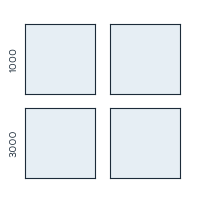

In [3]:
plot_overview_h5()

In [85]:
def plot_forward_terminal_distribution(h5='debug_data.h5'):

    with h5py.File("debug_data.h5", 'r') as F:
        xs = F['forward/terminal/xTs'][...]*1.0
        ts = F['forward/terminal/ts'][...]*1.0

    mu_T = xs[..., 0].squeeze()
    sigma_T = xs[..., 1].squeeze()

    fig, ax = plt.subplot_mosaic("MS", figsize=(14,5))
    ax['M'].hist(mu_T.flatten(), bins=100)
    ax['S'].hist(sigma_T.flatten(), bins=100)

    ax['M'].set_title("Histogram of $\mu_T$")
    ax['S'].set_title("Histogram of $\sigma_T$")

    fig.show()

    print(f"\\mu_T = \\mathcal{{N}}({mu_T.mean()}, {mu_T.std()})")
    print(f"\\sigma_T = \\mathcal{{N}}({sigma_T.mean()}, {sigma_T.std()})")

    M,N = (10,5)
    fig, axs = plt.subplots(N, M, figsize=(M, N))

    count = 0
    for i in range(N):
        for j in range(M):

            axs[i,j].imshow(xs[count,0,...,0])
            axs[i,j].set_axis_off()

            count += 1

    fig.show()

    M,N = (10,5)
    fig, axs = plt.subplots(N, M, figsize=(M, N))

    count = 0
    for i in range(N):
        for j in range(M):

            axs[i,j].imshow(np.random.randn(8,8))
            axs[i,j].set_axis_off()

            count += 1

    fig.show()
    
    
def plot_forward_terminal_distribution_per_dimension(h5='debug_data.h5'):

    with h5py.File("debug_data.h5", 'r') as F:
        xs = F['forward/terminal/xTs'][...]*1.0
        ts = F['forward/terminal/ts'][...]*1.0

    mu_T = xs[..., 0].squeeze()
    sigma_T = xs[..., 1].squeeze()
    
    mu_T = mu_T.reshape((mu_T.shape[0], -1))
    sigma_T = sigma_T.reshape((sigma_T.shape[0], -1))
       
    nbins=100   
    X = np.arange(mu_T.shape[-1])
    
    #get the limits based on the first variable:
    _, Y_mu = np.histogram(mu_T[:,0], bins=nbins)
    _, Y_sigma = np.histogram(sigma_T[:,0], bins=nbins)
    #Use these same bins for all other variables:
    mu_dist = [np.histogram(mu_T[:,i], bins=Y_mu)[0][:, np.newaxis] for i in range(mu_T.shape[-1])]
    sigma_dist = [np.histogram(sigma_T[:,i], bins=Y_sigma)[0][:, np.newaxis] for i in range(sigma_T.shape[-1])]
    #transform "bin edges" to Y values by dropping one of them
    Y_mu = Y_mu[1:]
    Y_sigma = Y_sigma[1:]
    
    mu_dist = np.concatenate(mu_dist, axis=1)
    sigma_dist = np.concatenate(sigma_dist, axis=1)
    
    fig, axs = plt.subplots(1,2,figsize=(12,4))
    
    X_mu, Y_mu = np.meshgrid(X, Y_mu)
    axs[0].pcolormesh(X_mu, Y_mu, mu_dist)
    
    X_sigma, Y_sigma = np.meshgrid(X, Y_sigma)
    axs[1].pcolormesh(X_sigma, Y_sigma, sigma_dist)
    
    
    axs[0].set_xlabel("Dimension $i$, as in $x_i$")
    axs[1].set_xlabel("Dimension $i$, as in $x_i$")
    
    axs[0].set_ylabel("Value")
    axs[1].set_ylabel("Value")
    
    axs[0].set_title("$\mu$ distribution for each dimension")
    axs[1].set_title("$\sigma$ distribution for each dimension")
  

%matplotlib inline
plot_forward_terminal_distribution()
plot_forward_terminal_distribution_per_dimension()


KeyError: 'Unable to open object (component not found)'

# Backward trajectory

Constructing backward_data_distribution_vs_timestep.gif


  0%|          | 0/1 [00:00<?, ?it/s]

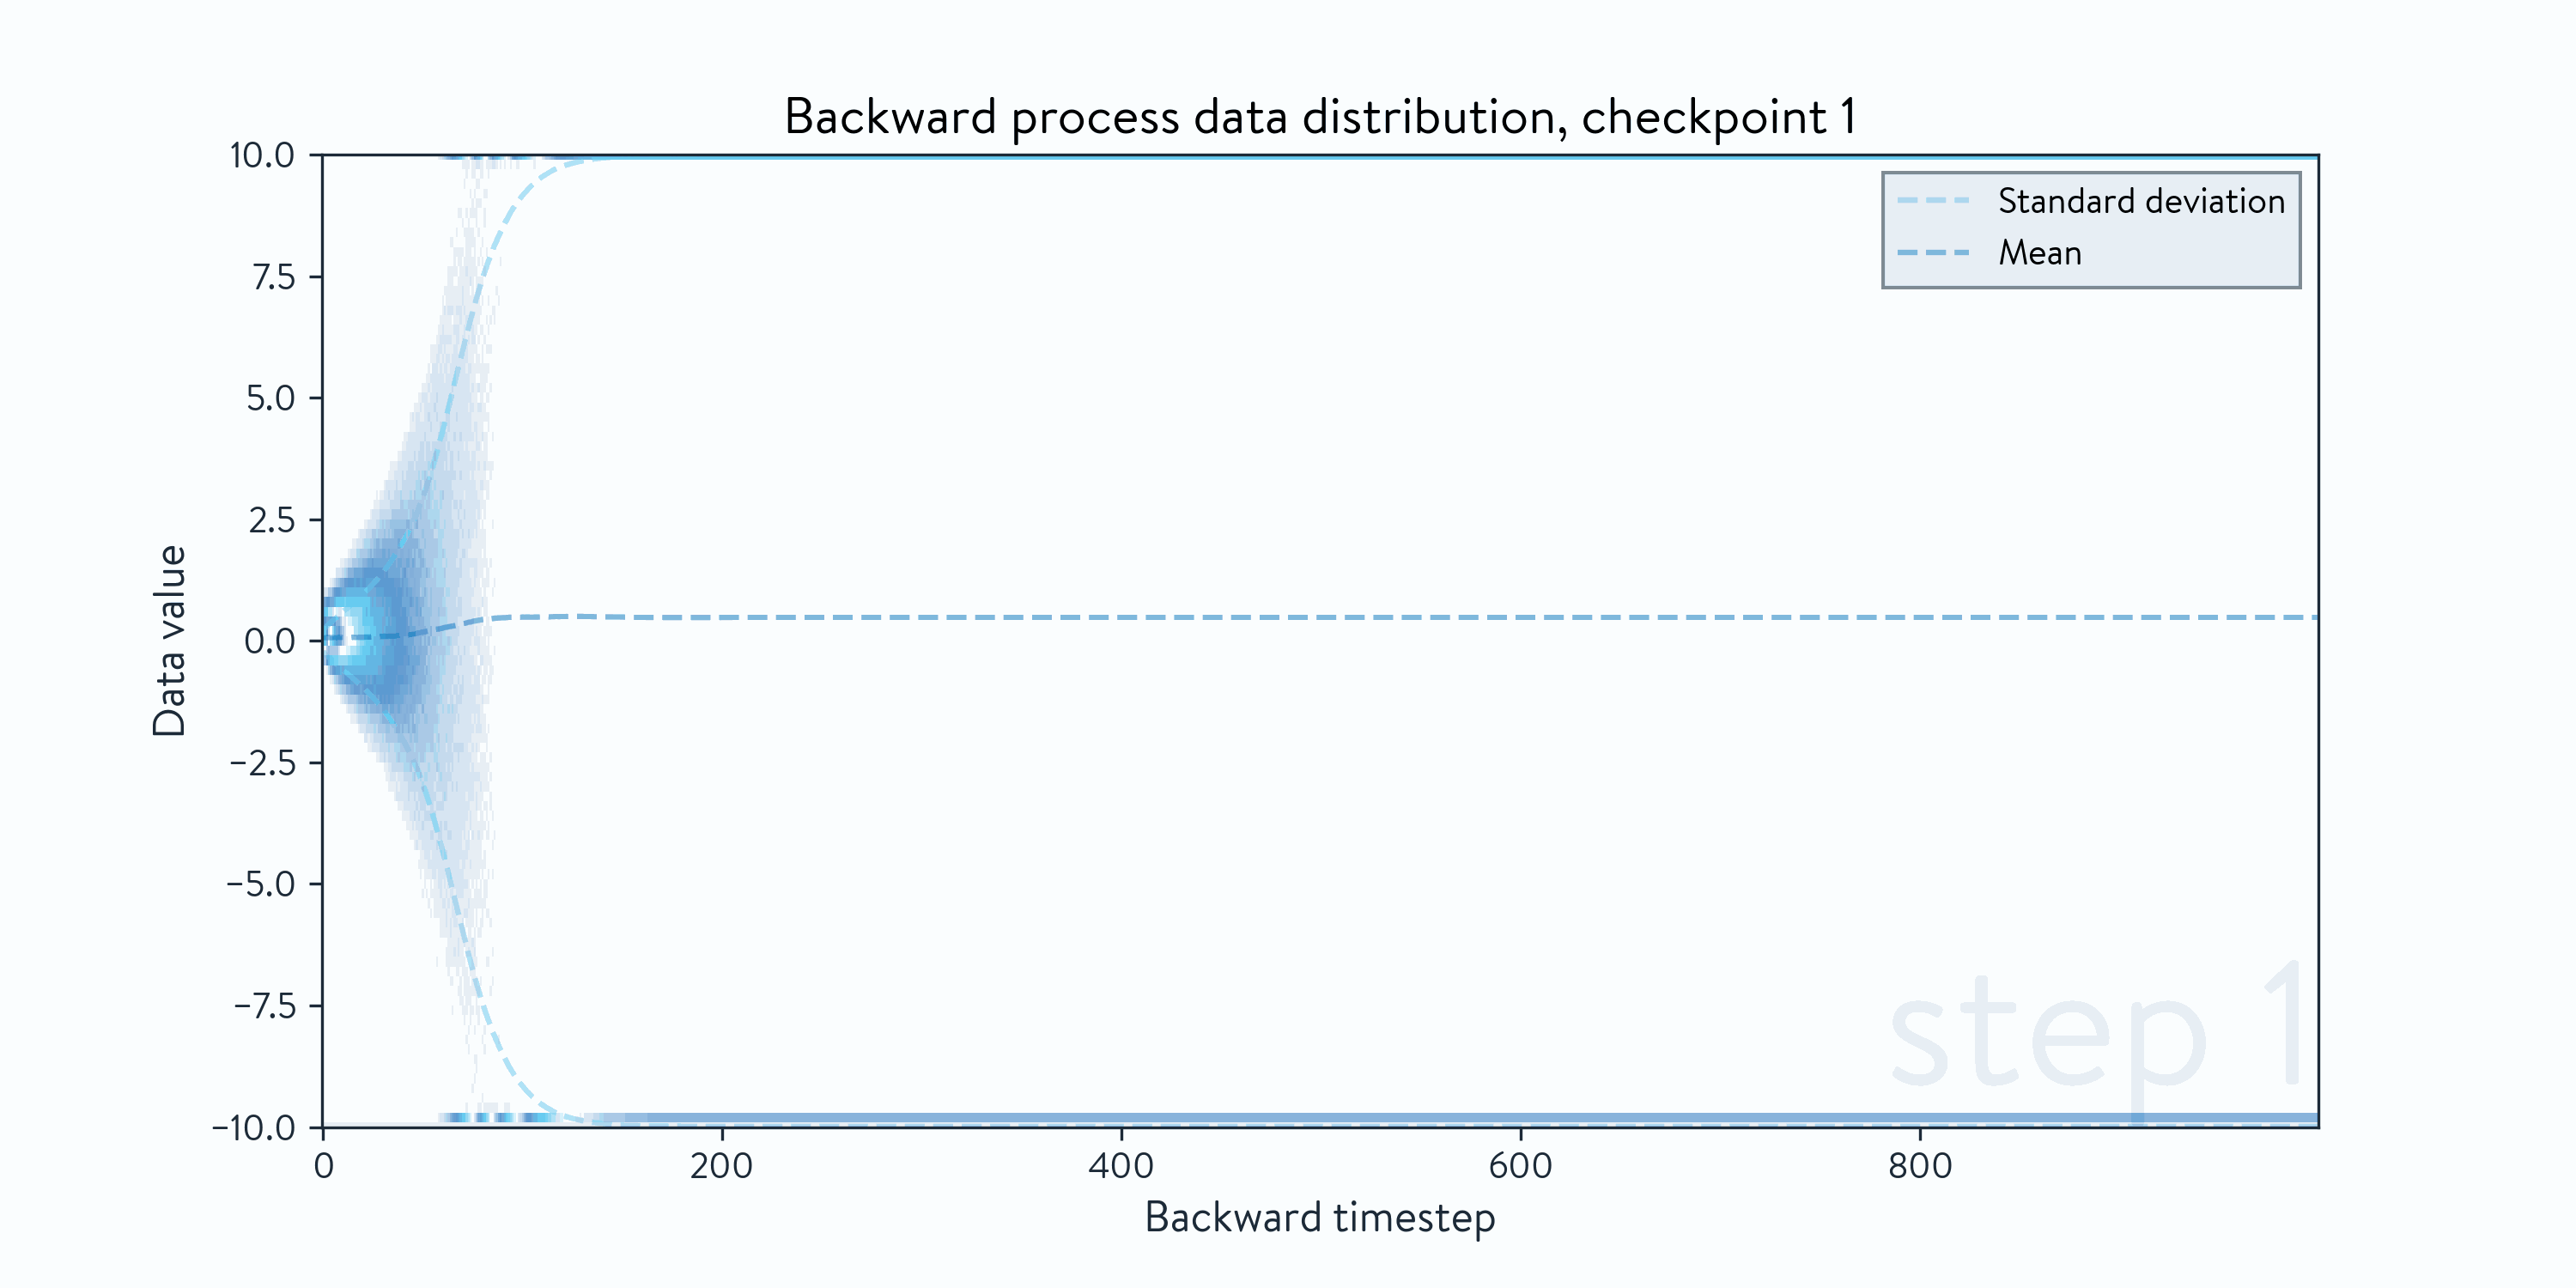

In [63]:
import matplotlib
%matplotlib inline
import gif
from tqdm import tqdm_notebook as tqdm
from IPython.display import Image
from plot1qbit import plot_to_gif
import numpy as np

np.seterr(all="ignore")


def backward_data_distribution_vs_timestep(chkpt=1000):
    with h5py.File("debug_data.h5", 'r') as F:
        d = F[f'backward/trajectory_chkpt_{chkpt}/xs'][...]
        #d[np.isnan(d)] = 0
        

    ylim=(-10,10)    

    bins=100
    T = d.shape[0]
    histdata = np.zeros((T, bins))

    for t in range(T):
        histdata[t,:], edges = np.histogram(d[t, ...].flatten(), bins=100, range=ylim)

    stds = np.std(d.reshape((d.shape[0], -1)), axis=1)
    means = np.mean(d.reshape((d.shape[0], -1)), axis=1)

    X, Y = np.meshgrid(np.arange(T), edges[1:])

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "",
        np.concatenate([["white", "blue", "C4"] for i in range(5)]) )
    
    

    
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    ax.grid(False)
    ax.pcolormesh(X, Y, histdata.T, cmap=cmap)

    ax.plot(np.arange(T), stds, '--', color='C4', label='Standard deviation', alpha=0.5)
    ax.plot(np.arange(T), -stds, '--', color='C4', alpha=0.5)
    ax.plot(np.arange(T), means, '--', color='C2', label='Mean', alpha=0.5)
    
    ax.text(1.0, 0.0, f"step {chkpt}", va='bottom', ha='right', size=50, alpha=0.07, transform=ax.transAxes)

    ax.legend()

    ax.set_title(f"Backward process data distribution, checkpoint {chkpt}")

    ax.set_xlabel("Backward timestep")
    ax.set_ylabel("Data value")

    ax.set_ylim(ylim)


steps = range(1,2,1)
plot_to_gif(func=backward_data_distribution_vs_timestep, ts=steps, gif_params={"duration":500, "unit":'ms', "between":'frames'})


#frames = [backward_data_distribution_vs_timestep(t) for t in tqdm(range(*steps))]
#gif.save(frames,"backward_data_distribution_vs_timestep.gif", duration=1000, unit='ms', between='frames')   

#Image("backward_data_distribution_vs_timestep.gif")

#interactive_plot = interactive(backward_data_distribution_vs_timestep, chkpt=steps)
#interactive_plot

Constructing backward_data_trajectory.gif


  0%|          | 0/23 [00:00<?, ?it/s]

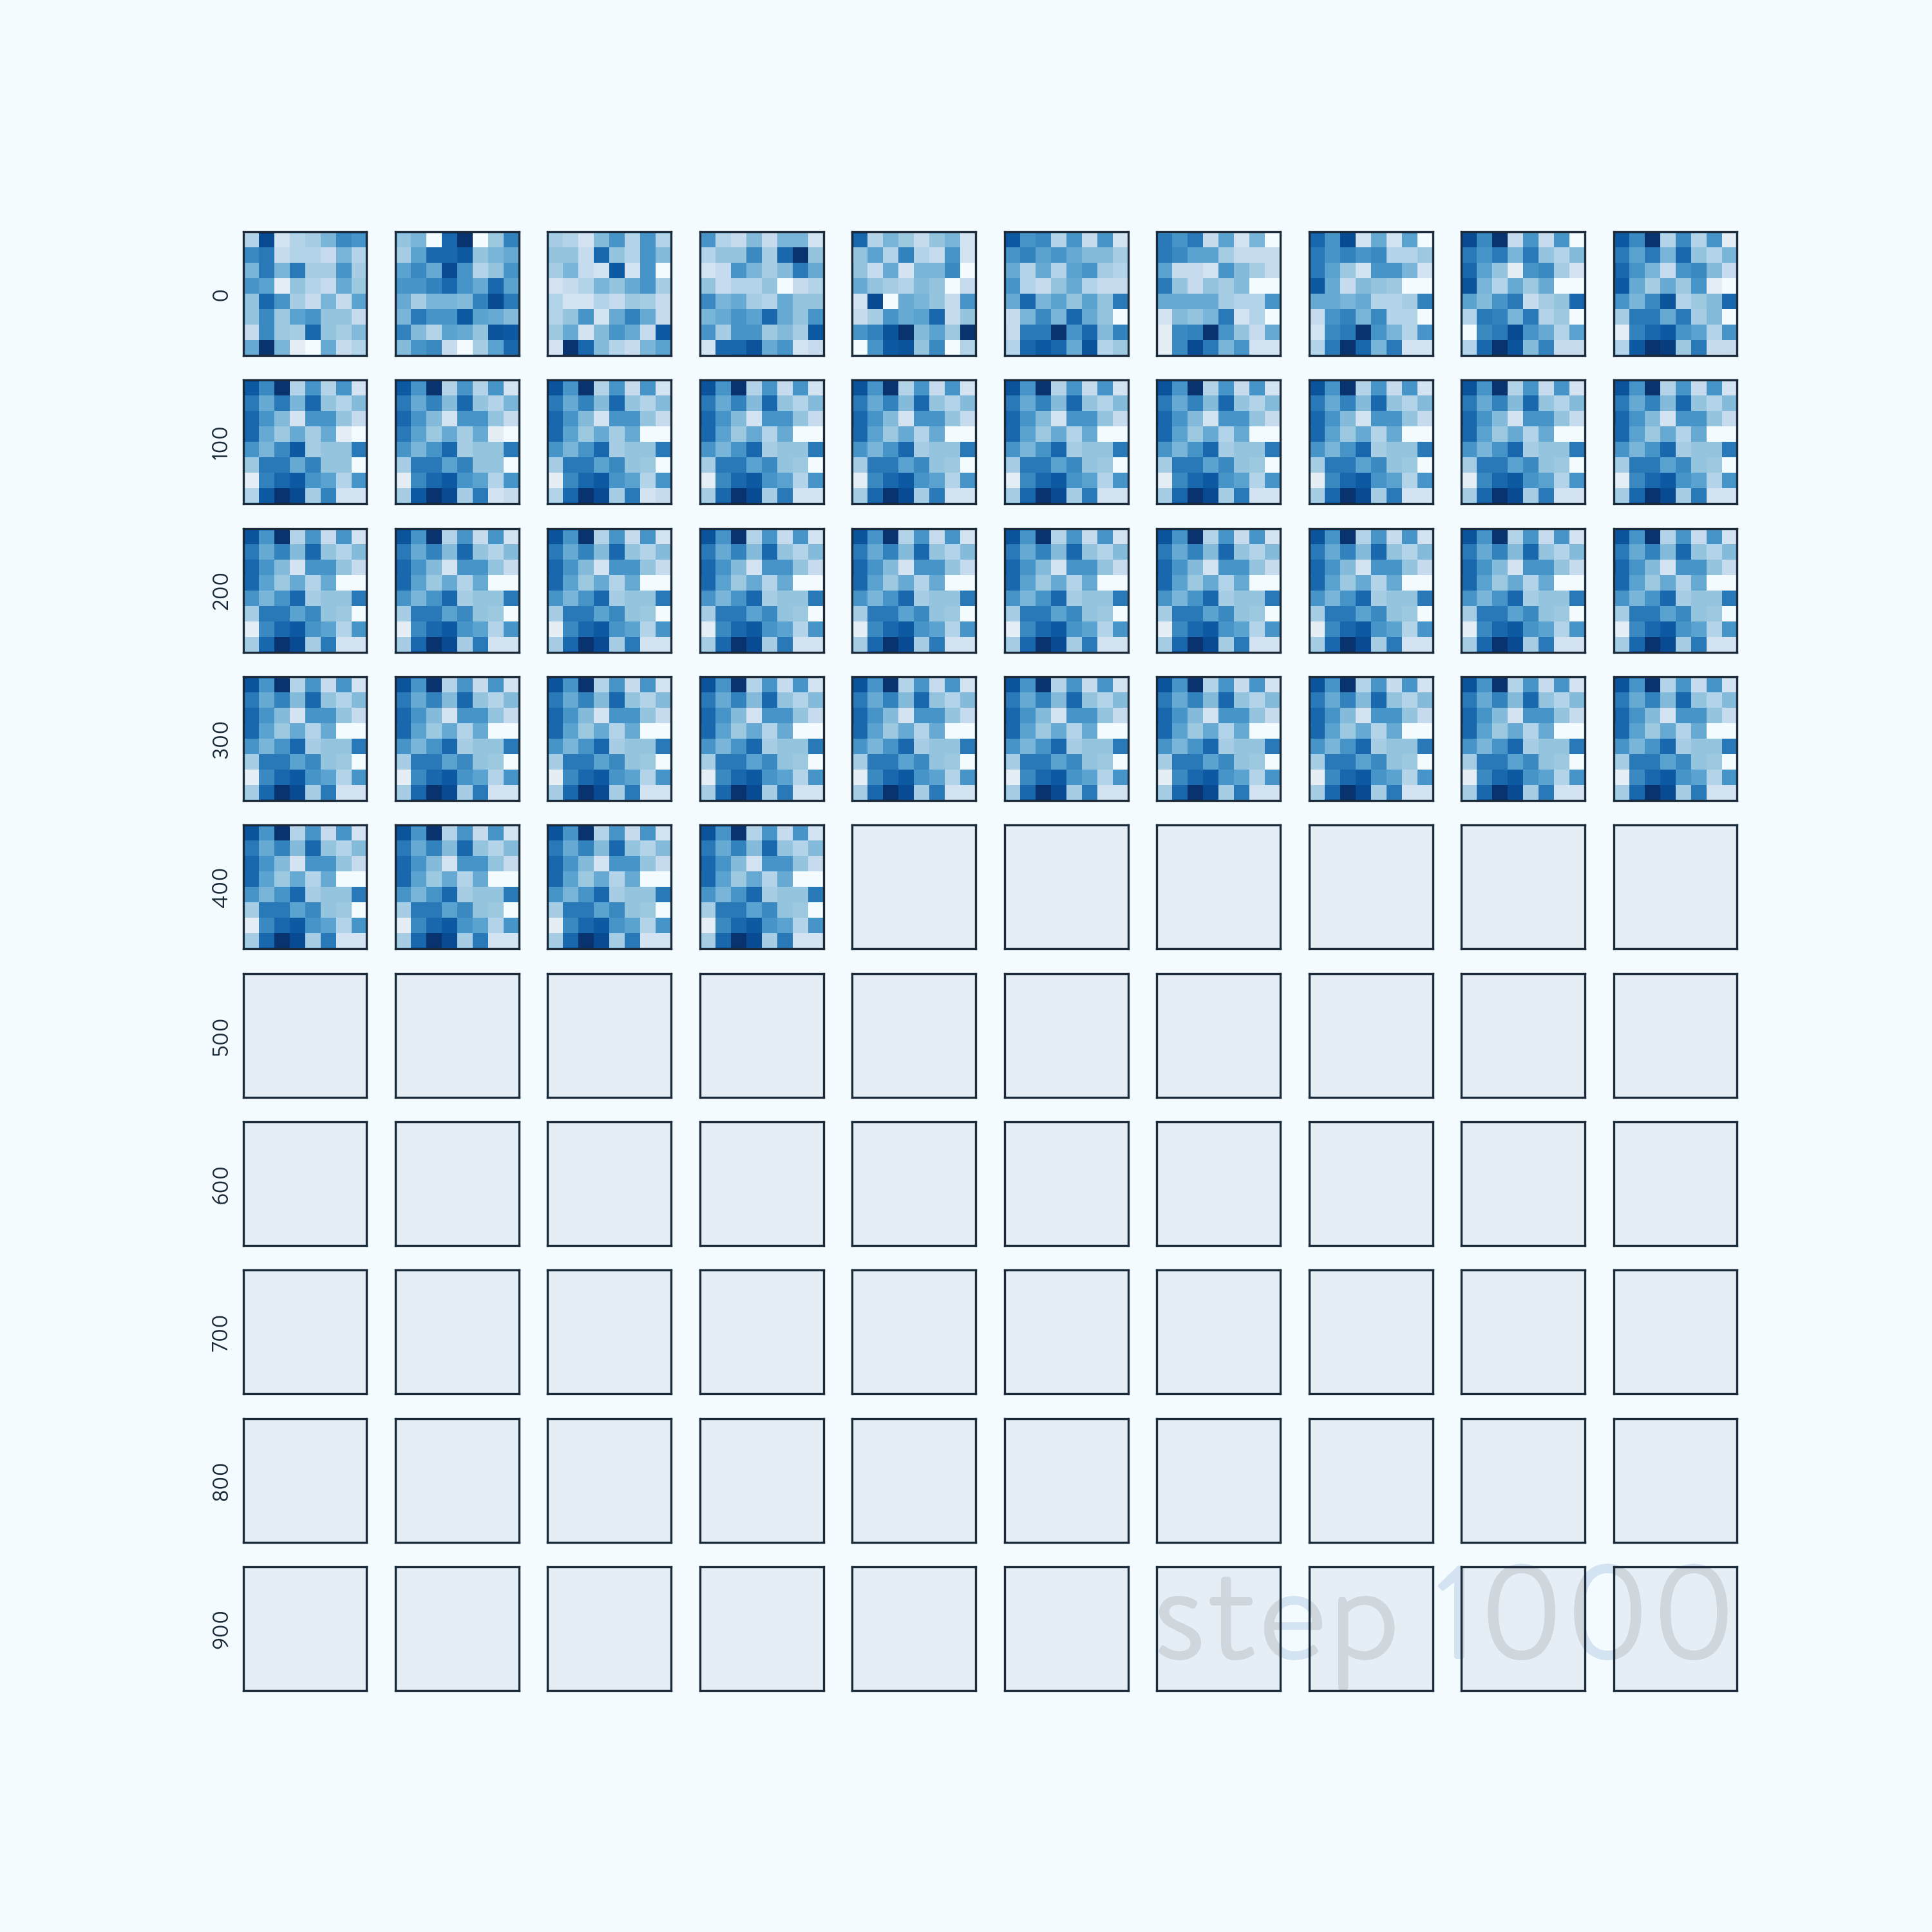

In [41]:
def backward_data_trajectory(chkpt=1000):

    with h5py.File("debug_data.h5", 'r') as F:
        d = F[f'backward/trajectory_chkpt_{chkpt}/xs'][...]
        #d[np.isnan(d)] = 0


    stride = 10
    M, N = ( int(np.ceil(np.sqrt(d.shape[0]/stride))),)*2

    fig1, axs1 = plt.subplots(M, N, figsize=(N, M))

    count = 0
    for i in range(M):
        for j in range(N):
            axs1[i, j].set_axis_off()
            if count >= d.shape[0]:
                continue
            axs1[i, j].imshow(d[count, 0, 0, ...])
            axs1[i,j].set_axis_on()
            axs1[i,j].set_xticks([])
            axs1[i,j].set_yticks([])
            if j==0:
                axs1[i, j].set_ylabel(str(count), size=8)

            count += stride

    axs1[-1,-1].text(1.0, 0.0, f"step {chkpt}", va='bottom', ha='right', size=50, alpha=0.1, transform=axs1[-1,-1].transAxes)


steps = range(1000,24000,1000)
plot_to_gif(func=backward_data_trajectory, ts=steps, gif_params={"duration":500, "unit":'ms', "between":'frames'})



## Importance sampler

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  app.launch_new_instance()


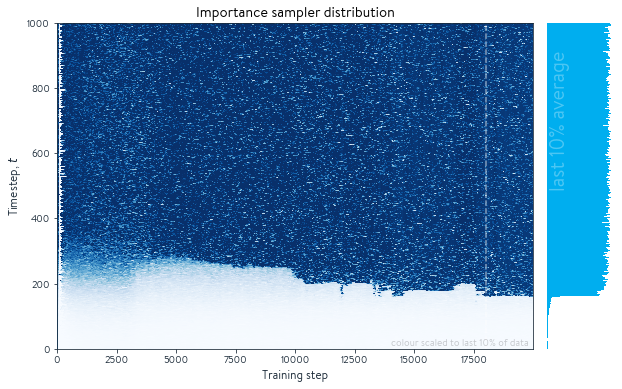

In [42]:
def plot_importance_sampler_distribution(h5="debug_data.h5", terminal_step=None):

    fig, axs = plt.subplot_mosaic("AAAAAAB", figsize=(10,6))

    
    with h5py.File(h5, 'r') as F:
        if terminal_step is not None:
            d = F[f'training/importance/pts'][:terminal_step, ...]
        else:
            d = F[f'training/importance/pts'][...]    


    X = np.arange(d.shape[0])
    Y = np.arange(d.shape[1])


    axs["A"].pcolormesh(X, Y, d.T, vmin=d[-d.shape[0]//10:, :].min(), vmax=d[-d.shape[0]//10:, :].max())
    axs["B"].barh(np.arange(d.shape[1]), d[-d.shape[0]//10:, :].mean(axis=0), height=1.0)
    axs["A"].axvline(x=d.shape[0]-d.shape[0]//10, linestyle='--', color='white', alpha=0.5)
    axs["A"].text(0.99, 0.0, "colour scaled to last 10% of data", ha='right', va='bottom', size=10, alpha=0.2, transform=axs["A"].transAxes)

    tmp = d[-d.shape[0]//10: , :].mean(axis=0)
    axs["A"].set_ylim(0,d.shape[1])


    axs["B"].set_ylim(0,d.shape[1])
    axs["B"].text(0.05, 0.5, "last 10% average", color="white", size=20, alpha=0.3, rotation=90, transform=axs["B"].transAxes)

    axs["B"].set_axis_off()

    axs["A"].set_title("Importance sampler distribution")

    axs["A"].set_ylabel("Timestep, $t$")
    axs["A"].set_xlabel("Training step")

    fig.show()
    
plot_importance_sampler_distribution(h5='debug_data_last.h5', terminal_step=20000)

# Score function distribution

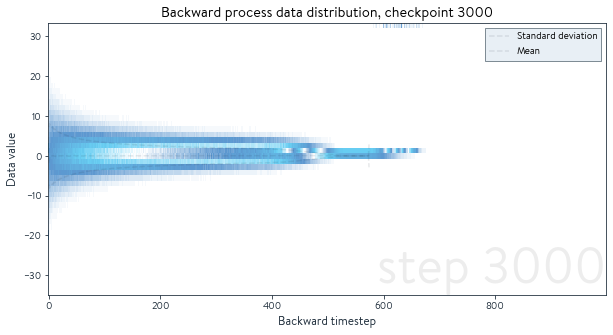

In [49]:
def score_function_input_distribution(h5='debug_data.h5', chkpt=1):
    with h5py.File(h5, 'r') as F:
        d = F[f'backward/score_evaluation_chkpt_{chkpt}/score'][...]
        infs = d==np.inf
        d[infs] = np.nanmax(d[~infs])
        
    
    ylim=(np.nanmin(d), np.nanmax(d))

    bins=50
    T = d.shape[0]
    histdata = np.zeros((T, bins))

    for t in range(T):
        histdata[t,:], edges = np.histogram(d[t, ...].flatten(), bins=bins, range=ylim)

    stds = np.std(d.reshape((d.shape[0], -1)), axis=1)
    means = np.mean(d.reshape((d.shape[0], -1)), axis=1)

    X, Y = np.meshgrid(np.arange(T), edges[1:])
    
    
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    ax.grid(False)
    ax.pcolormesh(X, Y, histdata.T, cmap='1qbit5')

    ax.plot(np.arange(T), stds, '--', color='C1', label='Standard deviation', alpha=0.1)
    ax.plot(np.arange(T), -stds, '--', color='C1', alpha=0.1)
    ax.plot(np.arange(T), means, '--', color='C1', label='Mean', alpha=0.1)
    
    ax.text(1.0, 0.0, f"step {chkpt}", va='bottom', ha='right', size=50, alpha=0.07, transform=ax.transAxes)

    ax.legend()

    ax.set_title(f"Backward process data distribution, checkpoint {chkpt}")

    ax.set_xlabel("Backward timestep")
    ax.set_ylabel("Data value")

    #ax.set_ylim(ylim)

score_function_input_distribution(h5='debug_data.h5', chkpt=3000)

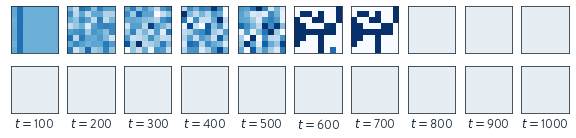

In [58]:
def backward_score_x_trajectory(h5='debug_data_last.h5', chkpt=1000):

    with h5py.File(h5, 'r') as F:
        d_xs = F[f'backward/score_evaluation_chkpt_{chkpt}/xs'][...]
        d_sc = F[f'backward/score_evaluation_chkpt_{chkpt}/score'][...]
        #d[np.isnan(d)] = 0
        
    stride = 100
    
  
    d_xs_range = dict(vmin=-1, vmax=1)
    
    N = d_xs.shape[0] // stride

    fig1, axs1 = plt.subplots(2, N, figsize=(N, 2))

    t = 0
    for j in range(N):
        if t >= d_xs.shape[0]:
            continue
        axs1[0,j].imshow(d_xs[t, 0, 0, ...], **d_xs_range )
        axs1[0,j].set_axis_on()
        axs1[0,j].set_xticks([])
        axs1[0,j].set_yticks([])
        t += stride
    t = 0
    for j in range(N):
        if t >= d_sc.shape[0]:
            continue
        axs1[1, j].imshow(d_sc[t, 0, 0, ...], vmin=np.nanmin(d_sc), vmax=np.nanmax(d_sc))
        axs1[1,j].set_axis_on()
        axs1[1,j].set_xticks([])
        axs1[1,j].set_yticks([])

        t += stride
        
        axs1[1, j].set_xlabel("$t=$"+str(t))

    #axs1[-1,-1].text(1.0, 0.0, f"step {chkpt}", va='bottom', ha='right', size=50, alpha=0.1, transform=axs1[-1,-1].transAxes)

    
%matplotlib inline
backward_score_x_trajectory(h5='debug_data.h5', chkpt=3000)

